# Doraemon experiment

In [ ]:
from doraemon.doraemon import train_test_ppo_with_doraemon
import os

n_episodes = 20000
mean_timestep = 300
target_env = "CustomHopper-target-v0"
source_env = "CustomHopper-source-v0"

# optimized for PPO without UDR in source environment
optimized_clip_range = 0.19877024509129543
optimized_learning_rate = 0.0008
optimized_gamma = 0.992

seeds = [10]

epsilon = 0.05
step = 2
delta = 0.5
alpha = 0.5

for seed in seeds:
	output_folder = f"doraemon-out/e{epsilon}-a{alpha}-d{delta}-s{step}-seed{seed}"

	os.mkdir(output_folder)

	# os.mkdir(f"{output_folder}/")

	print(f"PARAMETERS => eps: {epsilon}, step: {step}, delta: {delta}, alpha: {alpha}")
	train_test_ppo_with_doraemon(
		output_folder=f"{output_folder}/",
		train_env=source_env,
		test_env=target_env,
		episodes=n_episodes,
		clip_range=optimized_clip_range,
		learning_rate=optimized_learning_rate,
		gamma=optimized_gamma,
		timesteps=mean_timestep,
		print_std_deviation=True,
		seed=seed,
		epsilon = epsilon,
		step = step,
		delta = delta,
		alpha = alpha
	)

PARAMETERS => eps: 0.05, step: 2, delta: 0.5, alpha: 0.5


/opt/miniconda3/envs/mldl_m4/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean episode length
344.70860261381586
mean train reward
1082.3255381721256
mean test reward
976.112373179446
test rewards file: doraemon-out/e0.05-a0.5-d0.5-s2-seed10--//test_rewards_CustomHopper-target-v0.txt
mean test std
188.7446950130784


Mean test reward for UDR 0.5: 865.1782438419245
Mean test reward for doraemon standard parameters: 934.3534915732765
Mean test reward for doraemon optimized experiment: 829.7568623750891


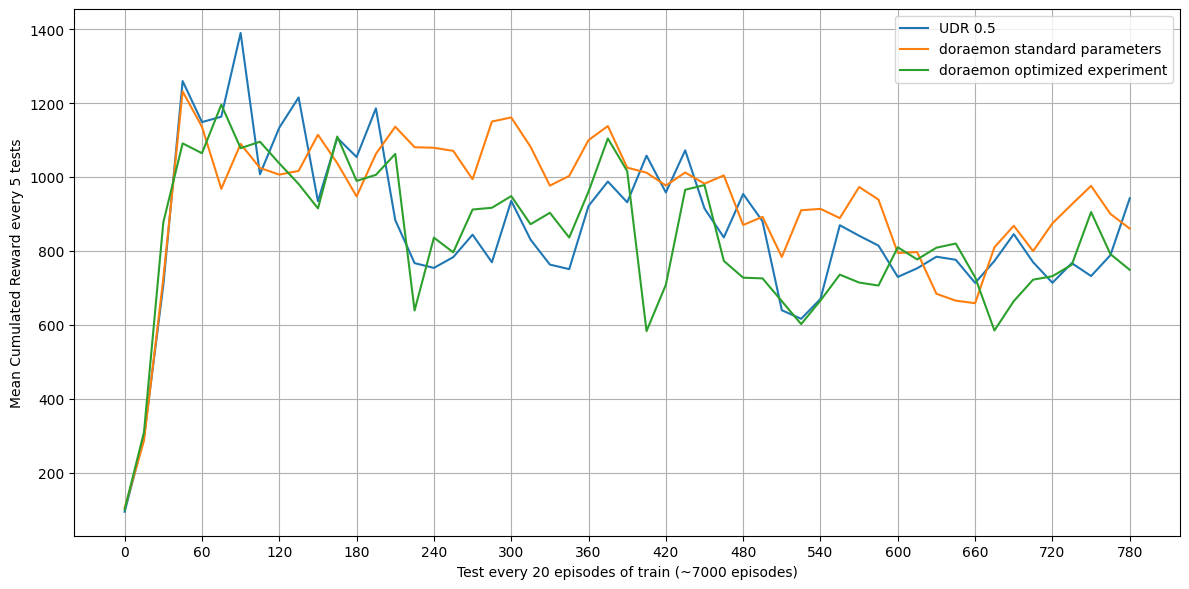

In [ ]:
import matplotlib.pyplot as plt

labels = ['UDR 0.5', 'doraemon standard parameters', 'doraemon optimized experiment']
def plot_group_means_no_window(file_list):
    assert len(file_list) % len(labels) == 0, "The number should be multiple of 3"
    plt.figure(figsize=(12, 6)) 

    for i in range(0, len(file_list), 3):
        group = file_list[i:i+3]

        all_values = []

        for filename in group:
            with open(filename, 'r') as f:
                lines = f.readlines()
                # Excludes the first row (head)
                values = [float(line.strip()) for line in lines[1:]]
                all_values.append(values)

        min_len = 800

        all_values = [v[:min_len] for v in all_values]

        # Computes the average for episode
        pointwise_mean = [
            sum(vals) / len(vals)
            for vals in zip(*all_values)
        ]

        # Groups every 50 values and computes the average per block
        block_size = 15
        num_blocks = len(pointwise_mean) // block_size
        pointwise_mean_blocked = [
        sum(pointwise_mean[i*block_size:(i+1)*block_size]) / block_size
        for i in range(num_blocks)]


        print(f"Mean test reward for {labels[i//3]}: {sum(pointwise_mean) / len(pointwise_mean)}")
        # Plot
        plt.plot(pointwise_mean_blocked, markersize=3, label=labels[i//3])
    # Number of plotted blocks
    num_blocks = len(pointwise_mean_blocked)

    tick_interval = 4 

    xticks_positions = list(range(0, num_blocks, tick_interval))
    xticks_labels = [str(i * block_size) for i in xticks_positions]

    plt.xticks(xticks_positions, xticks_labels)

    plt.xlabel('Test every 20 episodes of train (~7000 episodes)')
    plt.ylabel('Mean Cumulated Reward every 5 tests')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

file_list = [
    'trained-models/udr/seed-10/0.5/test_rewards_CustomHopper-target-v0.txt',
    'trained-models/udr/seed-20/0.5/test_rewards_CustomHopper-target-v0.txt',
    'trained-models/udr/seed-40/0.5/test_rewards_CustomHopper-target-v0.txt',
    
    "trained-models/doraemon/e0.05-a0.5-d0.5-s2.0/seed-10/test_rewards_CustomHopper-target-v0.txt",
    "trained-models/doraemon/e0.05-a0.5-d0.5-s2.0/seed-20/test_rewards_CustomHopper-target-v0.txt",
    "trained-models/doraemon/e0.05-a0.5-d0.5-s2.0/seed-40/test_rewards_CustomHopper-target-v0.txt",

    "trained-models/doraemon/e0.09-a0.5-d0.18-s2.5/seed-10/test_rewards_CustomHopper-target-v0.txt",
    "trained-models/doraemon/e0.09-a0.5-d0.18-s2.5/seed-20/test_rewards_CustomHopper-target-v0.txt",
    "trained-models/doraemon/e0.09-a0.5-d0.18-s2.5/seed-40/test_rewards_CustomHopper-target-v0.txt"
]

plot_group_means_no_window(file_list)

### Test only: udr 0.5 vs Doraemon

In [21]:
from PPO.ppo_test import test_ppo_policy

udr_model = "udr_output/seed-10/0.5/model.mdl"
doraemon_model = "doraemon-out/e0.05-a0.5-d0.5-s2-seed10--/model.mdl"
source_model = "trained-models/ppo/ppo_model_trained_on_source.mdl"

target_env = "CustomHopper-target-v0"
source_env = "CustomHopper-source-v0"

print("UDR SOURCE->TARGET TEST")
udr_rewards, udr_ep_len = test_ppo_policy(
    test_env=target_env, 
    model=udr_model
)
mean_udr_reward = sum(udr_rewards)/len(udr_rewards)
mean_udr_ep_len = sum(udr_ep_len)/len(udr_ep_len)

print("Doraemon SOURCE->TARGET TEST")
doraemon_rewards, doraemon_ep_len = test_ppo_policy(
    test_env=target_env, 
    model=doraemon_model
)
mean_doraemon_reward = sum(doraemon_rewards)/len(doraemon_rewards)
mean_doreamon_ep_len = sum(doraemon_ep_len)/len(doraemon_ep_len)

print("SOURCE->TARGET TEST")
source_target_rewards, source_target_ep_len = test_ppo_policy(
    test_env=target_env,
    model=source_model
)
mean_source_target_reward = sum(source_target_rewards)/len(source_target_rewards)
mean_source_target_ep_len = sum(source_target_ep_len)/len(source_target_ep_len)

UDR SOURCE->TARGET TEST
Action space: Box([-1. -1. -1.], [1. 1. 1.], (3,), float32)
State space: Box([-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf], [inf inf inf inf inf inf inf inf inf inf inf], (11,), float64)
Dynamics parameters: [3.53429174 3.92699082 2.71433605 5.0893801 ]
Doraemon SOURCE->TARGET TEST
Action space: Box([-1. -1. -1.], [1. 1. 1.], (3,), float32)
State space: Box([-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf], [inf inf inf inf inf inf inf inf inf inf inf], (11,), float64)
Dynamics parameters: [3.53429174 3.92699082 2.71433605 5.0893801 ]
SOURCE->TARGET TEST
Action space: Box([-1. -1. -1.], [1. 1. 1.], (3,), float32)
State space: Box([-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf], [inf inf inf inf inf inf inf inf inf inf inf], (11,), float64)
Dynamics parameters: [3.53429174 3.92699082 2.71433605 5.0893801 ]


doraemon mean test reward: 1082.8922368079586
udr mean test reward: 973.5935227573264
PPO mean test reward: 904.3695309058328


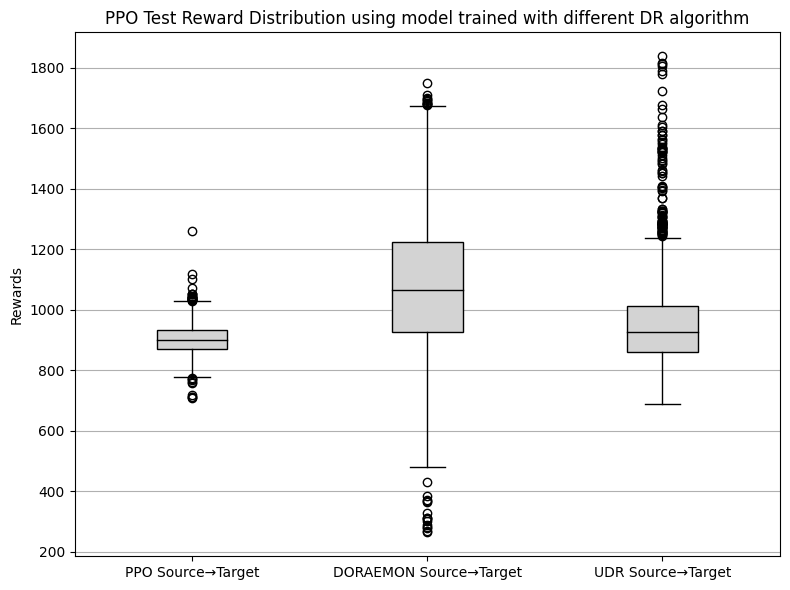

In [22]:
import matplotlib.pyplot as plt

print(f"doraemon mean test reward: {mean_doraemon_reward}")
print(f"udr mean test reward: {mean_udr_reward}")
print(f"PPO mean test reward: {mean_source_target_reward}")

# Each reward array should be a 1D array or list of floats
data = [
    source_target_rewards,
    doraemon_rewards,
    udr_rewards
]

labels = [
    'PPO Source→Target',
    'DORAEMON Source→Target',
    'UDR Source→Target'
]

plt.figure(figsize=(8, 6))

plt.boxplot(data, labels=labels, patch_artist=True,
            boxprops=dict(facecolor='lightgray'),
            medianprops=dict(color='black'))

plt.ylabel("Rewards")
plt.title("PPO Test Reward Distribution using model trained with different DR algorithm")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()